In [18]:
# --- IMPORTS

import numpy as np
import random
import matplotlib.pyplot as plt

In [19]:
# --- CLASSES

class Gibbs:
    def __init__(self, size):
        self.size = size
        self.base_lambda = 1/size
    
    def get_distribution(self, num_trials, W, b):
        pass
    
    def plot_distribution(self, num_trials, W, b):
        plt.bar(np.arange(0, 2**self.size), self.get_distribution(num_trials, W, b))
        plt.show()
        
    def state_to_int(self, s):
        binary = [0 if i == -1 else 1 for i in s]
        result = 0
        power_of_two = 1
        for bit in reversed(binary):
            result += power_of_two * bit
            power_of_two *= 2
        return result
    
class Discrete_Gibbs(Gibbs):
    def get_distribution(self, num_trials, W, b):
        s = [random.choice([-1, 1]) for i in range(self.size)]
        result = np.zeros(2**self.size)
        for k in range(num_trials):
            for i in range(self.size):
                summation = np.dot(W[i], s)
                s[i] = np.sign(np.tanh(summation + b[i]) + random.uniform(-1, 1))
                result[self.state_to_int(s)] += 1
        return result
    
class Continuous_Gibbs(Gibbs):
    def get_distribution(self, num_trials, W, b):
        s = [random.choice([-1, 1]) for i in range(self.size)]
        result = np.zeros(2**self.size)
        lambdas = [self.base_lambda] * self.size
        for k in range(num_trials):
            # competing exponentials
            times = [-np.log(1-np.random.uniform(0,1))/lambdas[i] for i in range(self.size)]

            # update the s[i] of the exponential that hit first
            argmin_time = np.argmin(times)
            result[self.state_to_int(s)] += times[argmin_time]
            s[argmin_time] = -s[argmin_time]

            # update summation, sigmoid, and lambdas
            sigmoids = np.multiply(np.add(np.tanh(np.add(np.matmul(s, W), b)), 1), 0.5)
            lambdas = [(1-sigmoids[i])*self.base_lambda if s[i] == 1 else sigmoids[i]*self.base_lambda for i in range(self.size)]
        return result

In [71]:
# FUNCTIONS

def max_cut(file_name, num_repetitions, num_trials):
    file1 = open(file_name,"r") 
    arr = file1.readline()[:-1].split("\t") # first line
    num_vertices = int(arr[0])

    W = np.zeros((num_vertices, num_vertices))

    for line in file1:
        arr = line[:-1].split("\t")
        ind1 = int(arr[0])
        ind2 = int(arr[1])
        ind3 = int(arr[2])
        W[ind1-1][ind2-1] = ind3

    cg = Continuous_Gibbs(num_vertices)
    b = np.zeros(num_vertices)

    result = []
    for _ in range(num_repetitions):
        dist = cg.get_distribution(num_trials, -3*W, b)
#         total = sum(dist)
#         for j in range(len(dist)):
#             print(j)
#             print(dist[j]/total)
#             print()
        best_state = np.argmax(dist)
        binary = [-1 if i == 0 else 1 for i in list(map(int, bin(best_state)[2:]))]
        with_zeros = [-1] * (num_vertices - len(binary)) + binary
        # calculate Hamiltonian
        H = 0
        for i in range(num_vertices):
            for j in range(num_vertices):
                H -= 2 * -W[i][j] * with_zeros[i] * with_zeros[j] # J = -W[i][j]
                
        # calculate cut
        cut = 0
        for i in range(num_vertices):
            outgoing_edges = W[i]
            for j in range(len(outgoing_edges)):
                if outgoing_edges[j] != 0: # edge exists between vertex i and vertex j
                    if with_zeros[i] != with_zeros[j]: # on different sides of the cut
                        cut += 1
                    
        result += [(best_state, H, cut)]
    return result

def calculate_distribution(file_name):
    file1 = open(file_name,"r") 
    arr = file1.readline()[:-1].split("\t") # first line
    num_vertices = int(arr[0])

    W = np.zeros((num_vertices, num_vertices))

    for line in file1:
        arr = line[:-1].split("\t")
        ind1 = int(arr[0])
        ind2 = int(arr[1])
        ind3 = int(arr[2])
        W[ind1-1][ind2-1] = ind3
    
    result = []
    for i in range(2**num_vertices):
        binary = [-1 if i == 0 else 1 for i in list(map(int, bin(i)[2:]))]
        with_zeros = [-1] * (num_vertices - len(binary)) + binary
        numerator = np.exp(np.dot(np.dot(with_zeros, W),with_zeros).T)
        result += [numerator]
    denominator = sum(result)
    return result/denominator
        

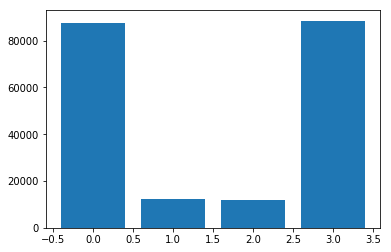

In [16]:
# RUNTIME

dg2 = Discrete_Gibbs(2)
W = np.array([[0, 1], [1, 0]])
b = np.array([0, 0])
dg2.plot_distribution(100000, W, b)

In [17]:
dg3 = Discrete_Gibbs(3)
w_12 = -1
w_13 = 2
w_21 = -1
w_23 = 2
w_31 = 2
w_32 = 2
b_1 = 1
b_2 = 1
b_3 = -2

W = np.array([[0, w_12, w_13], [w_21, 0, w_23], [w_31, w_32, 0]])
b = np.array([b_1, b_2, b_3])

dg3.plot_distribution(100000, W, b)

KeyboardInterrupt: 

In [ ]:
cg2 = Continuous_Gibbs(2)
W = np.array([[0, 1], [1, 0]])
b = np.array([0, 0])
cg2.plot_distribution(100000, W, b)

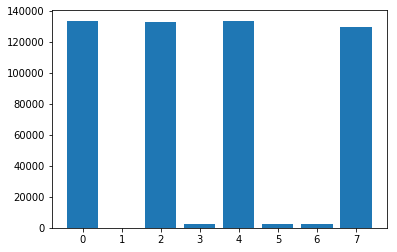

In [13]:
cg3 = Continuous_Gibbs(3)
w_12 = -1
w_13 = 2
w_21 = -1
w_23 = 2
w_31 = 2
w_32 = 2
b_1 = 1
b_2 = 1
b_3 = -2

W = np.array([[0, w_12, w_13], [w_21, 0, w_23], [w_31, w_32, 0]])
b = np.array([b_1, b_2, b_3])

cg3.plot_distribution(100000, W, b)

In [ ]:
# small graph test
W = np.array([[0, 2, 0], 
              [0, 0, 1],
              [0, 0, 0],
             ])

cg5 = Continuous_Gibbs(3)
b = np.array([0, 0, 0])

result = []
for _ in range(10):
    dist = cg5.get_distribution(100000, -W, b)
    best_state = np.argmax(dist)
    binary = [-1 if i == 0 else 1 for i in list(map(int, bin(best_state)[2:]))]
    with_zeros = [-1] * (3 - len(binary)) + binary
    H = 0
    for i in range(3):
        for j in range(3):
            H -= W[i][j] * with_zeros[i] * with_zeros[j]
    result += [(best_state, H)]
result

In [75]:
max_cut("N010-id00.txt", 10, 100000)

[(550, -22.0, 17),
 (473, -22.0, 17),
 (550, -22.0, 17),
 (473, -22.0, 17),
 (473, -22.0, 17),
 (473, -22.0, 17),
 (473, -22.0, 17),
 (550, -22.0, 17),
 (550, -22.0, 17),
 (550, -22.0, 17)]

In [ ]:
max_cut("N010-id01.txt", 10, 100000)

[(361, -18.0, 16),
 (662, -18.0, 16),
 (361, -18.0, 16),
 (662, -18.0, 16),
 (662, -18.0, 16),
 (663, -18.0, 16),
 (662, -18.0, 16),
 (662, -18.0, 16),
 (361, -18.0, 16),
 (361, -18.0, 16)]

In [ ]:
max_cut("N010-id02.txt", 10, 100000)

In [23]:
max_cut("N010-id00.txt", 1, 100000)

0
2.1357460463355514e-05

1
4.04766230903175e-05

2
3.3567235382112075e-05

3
0.000130673768699507

4
4.5530923089667976e-05

5
6.720233913324071e-05

6
0.000370157518144125

7
0.0002944681436803733

8
1.4623075600805645e-05

9
8.439097255705161e-05

10
8.037830575133068e-05

11
0.0002149151224212096

12
0.00048627980445102646

13
0.0004122801263362138

14
0.0013388875271050512

15
0.00042976617585845523

16
1.9487995337926227e-05

17
3.255626187347325e-05

18
3.002838803796974e-05

19
0.00010524425480017416

20
3.292340645390247e-05

21
8.695581359458875e-05

22
0.00014598091415369074

23
8.829587856840734e-05

24
7.06286257194559e-05

25
0.00018221866180609706

26
5.544015761852716e-05

27
0.00010583210726976012

28
0.0005185570070025423

29
0.0006393616888389568

30
0.0005271170361791284

31
0.0002311666569112426

32
1.5680539461753936e-05

33
9.745239546562947e-05

34
0.0003215432619179939

35
0.0007083586024182173

36
0.00017910589574375758

37
0.00047668368502981037

38
0.0027992


683
0.00034265598880210186

684
0.0005886496906620836

685
0.0004070723844617611

686
0.0005165317640216542

687
8.736769272923451e-05

688
0.0002352018978363515

689
0.0011172086159318226

690
0.0005358581775982782

691
0.0012482433581823386

692
0.00041966065987590406

693
0.001287821311945327

694
0.000585407775520173

695
0.00036894963456507484

696
0.00018181947554046912

697
0.00044567518568576053

698
0.00011158821388433055

699
5.715705349504874e-05

700
0.0005119824353218263

701
0.0002855543655209219

702
0.00011015599574905928

703
3.12231617526293e-05

704
0.00023330861846991395

705
0.0007610134586664099

706
0.0010543664694827963

707
0.0006401950215387963

708
0.00044449726724899683

709
0.0005259073920850033

710
0.0009756140843820865

711
0.0004188544319608072

712
0.0004944035554572548

713
0.0003460169762407536

714
0.0005208487457281174

715
0.00019201916191941996

716
0.0006454918051552169

717
0.00033105902454613593

718
0.00045473416689654334

719
4.818247457880

[(550, 11.0)]

In [51]:
arr = calculate_distribution("N010-id00.txt")
for j in range(len(arr)):
    print(j)
    print(arr[j])
    print()

0
0.4893744459247173

1
2.2217565472537103e-05

2
3.0068205160537955e-06

3
7.45316289901341e-09

4
3.0068205160537955e-06

5
7.45316289901341e-09

6
1.008675911946593e-09

7
1.3650944023724077e-10

8
2.2217565472537103e-05

9
5.5071838775278675e-08

10
7.45316289901341e-09

11
1.008675911946593e-09

12
1.3650944023724077e-10

13
1.8474543758978434e-11

14
2.5002576122885418e-12

15
1.8474543758978434e-11

16
0.008963205632931492

17
4.069289061817984e-07

18
3.0068205160537955e-06

19
7.45316289901341e-09

20
5.5071838775278675e-08

21
1.3650944023724077e-10

22
1.008675911946593e-09

23
1.3650944023724077e-10

24
4.069289061817984e-07

25
1.008675911946593e-09

26
7.45316289901341e-09

27
1.008675911946593e-09

28
2.5002576122885418e-12

29
3.3837307212356677e-13

30
2.5002576122885418e-12

31
1.8474543758978434e-11

32
0.0012130379730407861

33
5.5071838775278675e-08

34
7.45316289901341e-09

35
1.8474543758978434e-11

36
4.069289061817984e-07

37
1.008675911946593e-09

38
1.3650944

2.5002576122885418e-12

662
1.8474543758978434e-11

663
1.3650944023724077e-10

664
7.45316289901341e-09

665
1.008675911946593e-09

666
7.45316289901341e-09

667
5.5071838775278675e-08

668
2.5002576122885418e-12

669
1.8474543758978434e-11

670
1.3650944023724077e-10

671
5.5071838775278675e-08

672
1.3650944023724077e-10

673
3.3837307212356677e-13

674
4.5793815555485684e-14

675
6.197518998686856e-15

676
2.5002576122885418e-12

677
3.3837307212356677e-13

678
4.5793815555485684e-14

679
3.3837307212356677e-13

680
1.008675911946593e-09

681
1.3650944023724077e-10

682
1.8474543758978434e-11

683
1.3650944023724077e-10

684
1.8474543758978434e-11

685
1.3650944023724077e-10

686
1.8474543758978434e-11

687
7.45316289901341e-09

688
1.3650944023724077e-10

689
3.3837307212356677e-13

690
2.5002576122885418e-12

691
3.3837307212356677e-13

692
2.5002576122885418e-12

693
3.3837307212356677e-13

694
2.5002576122885418e-12

695
1.8474543758978434e-11

696
1.008675911946593e-09

697
1.